**注**：
- 由于数据量太大还没对模型进行太多调参
- 此代码在本人电脑上可以跑通，kaggle上也能跑通
- kaggle上拥有可分享版本（调参版本），目前还未施工完成，着急的话我把它分享出来
- 调参部分请直接在本文档搜索关键词：<span style="background-color:yellow">参数
- <span style="color:red">使用前请先在终端中输入：</span><span style="color:yellow">```pip install -r requirements.txt```</span><span style="color:red">以确保环境正确</span>

## 1. 库导入

In [1]:
# 库导入
import os
import math
import torch
import random
import warnings
import numpy as np 
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.multiprocessing as mp
from torch.autograd import Variable
from keras.preprocessing import sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from prefetch_generator import BackgroundGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import precision_score, f1_score, accuracy_score

## wifi信号（x）
## 前排提示 
## 因为这份代码里面被本人删了又改改了又删 可能部分地方有些逻辑重复 望轻喷

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 2. 数据查看及整合后的数据处理函数

### 2.1 数据查看及图像绘制

In [2]:
# 文件读取
headers=["Tweet ID","entity","sentiment","Tweet content"]
train_data=pd.read_csv('./archive/twitter_training.csv',header=None,names=headers)
val_data=pd.read_csv('./archive/twitter_validation.csv',header=None,names=headers)

In [3]:
train_data.head(100)

,Tweet ID,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
95,2416,Borderlands,Neutral,I hate that this easy horrible modifier event ...
96,2417,Borderlands,Negative,Grounded almost looked pretty cool even despit...
97,2417,Borderlands,Negative,Grounded looked cool despite the borderline un...
98,2417,Borderlands,Negative,"Grosskreutz looked pretty cool, even despite t..."


In [4]:
val_data.head(100)

,Tweet ID,entity,sentiment,Tweet content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
95,9456,Overwatch,Negative,@BlizzardCS so when i try to buy overwatch wit...
96,11687,Verizon,Negative,@verizon Can you waive some data overage charg...
97,1589,Battlefield,Negative,No one buy battlefield 3 on steam! It doesn’t ...
98,3526,Facebook,Neutral,Our #HISAPerth #OBIawards ceremony is taking p...


In [5]:
## 查看标签数值化后的数据

# 提取出需要的部分
new_train_data = train_data.loc[:,['sentiment','Tweet content']].astype(str)
new_val_data = val_data.loc[:,['sentiment','Tweet content']].astype(str)

# 标签数值化
y_train,unique=pd.factorize(new_train_data['sentiment'])
new_train_data['sentiment']=y_train
y_val,unique=pd.factorize(new_val_data['sentiment'])
new_val_data['sentiment']=y_val

# 查看数据
new_train_data.head(100)

,sentiment,Tweet content
0,0,im getting on borderlands and i will murder yo...
1,0,I am coming to the borders and I will kill you...
2,0,im getting on borderlands and i will kill you ...
3,0,im coming on borderlands and i will murder you...
4,0,im getting on borderlands 2 and i will murder ...
...,...,...
95,1,I hate that this easy horrible modifier event ...
96,2,Grounded almost looked pretty cool even despit...
97,2,Grounded looked cool despite the borderline un...
98,2,"Grosskreutz looked pretty cool, even despite t..."


In [6]:
# 分词
tok=Tokenizer(num_words=100000)
tok.fit_on_texts(new_train_data['Tweet content'])
for i in range(10): print(f"{i+1}:{list(tok.word_index.keys())[i]}")

1:the
2:i
3:to
4:and
5:a
6:of
7:is
8:in
9:for
10:this


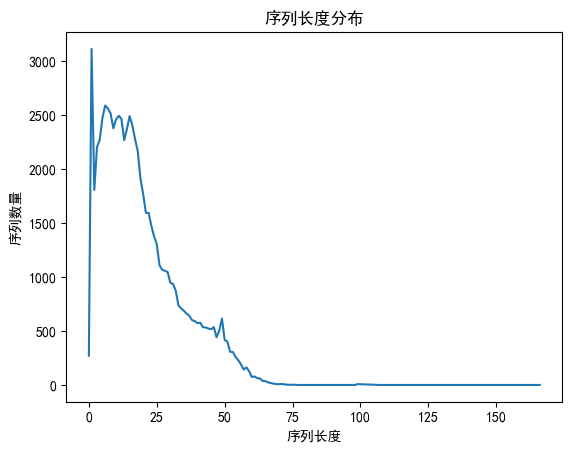

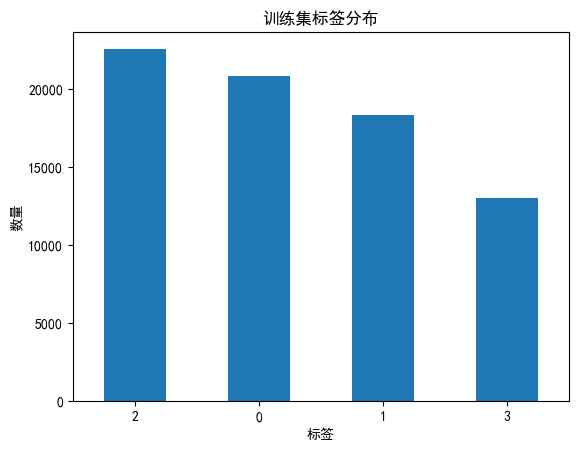

In [7]:
# 长度分布查看
x_train=tok.texts_to_sequences(new_train_data['Tweet content'].to_numpy())
len_ser=pd.Series([len(i) for i in x_train])
plt.plot(len_ser.value_counts().sort_index())
plt.xlabel('序列长度')
plt.ylabel('序列数量')
plt.title('序列长度分布')
plt.show()

# 查看情感类型分布
new_train_data['sentiment'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.title('训练集标签分布')
plt.xlabel('标签')
plt.ylabel('数量')
plt.show()


### 2.2 整合后的数据导入及处理函数

In [8]:
def load_data(device='cpu'):
    # 导入
    headers=["Tweet ID","entity","sentiment","Tweet content"]
    train_data=pd.read_csv('./archive/twitter_training.csv',header=None,names=headers)
    test_data=pd.read_csv('./archive/twitter_validation.csv',header=None,names=headers)

    # 取出有用部分
    new_train_data = train_data.loc[:,['sentiment','Tweet content']].astype(str)
    new_test_data = test_data.loc[:,['sentiment','Tweet content']].astype(str)

    # 标签数值化
    y_train,unique=pd.factorize(new_train_data['sentiment'])
    # y_train=y_train.to_numpy()
    y_test,unique=pd.factorize(new_test_data['sentiment'])
    # y_test=y_test.to_numpy()

    # 分词
    tok=Tokenizer(num_words=100000)
    tok.fit_on_texts(new_train_data['Tweet content'])

    x_train=tok.texts_to_sequences(new_train_data['Tweet content'].to_numpy())
    x_train = sequence.pad_sequences(x_train, maxlen=100)
    
    x_test=tok.texts_to_sequences(new_test_data['Tweet content'].to_numpy())
    x_test = sequence.pad_sequences(x_test, maxlen=100)

    # 转换为 tensor(为了防止后面梯度爆炸这里对数据进行了归一化)
    x_train = torch.tensor(x_train, dtype=torch.long, device=device)
    y_train = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1,1)
    x_test = torch.tensor(x_test, dtype=torch.long, device=device)
    y_test = torch.tensor(y_test, dtype=torch.float32, device=device).view(-1,1)
    # scaler=StandardScaler()
    # x_train=torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32, device=device)
    # x_test=torch.tensor(scaler.fit_transform(x_test), dtype=torch.float32, device=device)
    
    # 查看数据集大小
    print(f'训练集大小: {len(train_data)}')
    print(f'测试集大小: {len(test_data)}')
    
    return x_train,y_train,x_test,y_test,tok

# 数据集
class TwitterDataset(Dataset):
    def __init__(self,data,labels):
        self.data = data
        self.labels=labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.data[idx], self.labels[idx]

class TwitterDataLoader(DataLoader):
    def __iter__(self):
        return BackgroundGenerator(super().__iter__(), max_prefetch=32)

## 3.Transformer的encoder模型

In [9]:
## 模型部分
# Embedding部分
class InputEmbeddings(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(InputEmbeddings, self).__init__()
        self.embedding_dim = embedding_dim
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        
    def forward(self, x):
        return self.embed(x) * math.sqrt(self.embedding_dim)
    
# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len=100,dropout=0.2):
        super(PositionalEncoding, self).__init__()
        self.encoding=torch.zeros(max_len,embedding_dim)
        
        #三角位置编码
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * -(math.log(10000.0) / embedding_dim))
        
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)        # 增加一个维度以对齐
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = x + Variable(self.encoding[:, :x.size(1)].to(x.device), requires_grad=False) 
        return self.dropout(x)

# 多头注意力机制
## 注意力机制
def attention(q,k,v,mask=None,dropout=0.2):
    d_k = q.size(-1)
    scores = torch.matmul(q,k.transpose(-2,-1)) / math.sqrt(d_k)
    
    if mask is not None:
        scores = scores.masked_fill(mask==0,-1e9)
    patten=nn.functional.softmax(scores,dim=-1)
    if dropout is not None:
        patten=nn.functional.dropout(patten,dropout)
    return torch.matmul(patten,v),patten

## 多头注意力机制
class MultiHeadAttention(nn.Module):
    def __init__(self,h,d_model,dropout=0.2,linear_layers=3):
        super(MultiHeadAttention,self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linear_layers = nn.ModuleList([nn.Linear(d_model,d_model) for _ in range(linear_layers)])
        self.output_linear = nn.Linear(d_model,d_model)
        self.attention = attention
        self.dropout = nn.Dropout(dropout)
    
    def fordward(self,q,k,v,mask=None):
        if mask is not None:
            mask=mask.unsqueeze(1)
        batch_size = q.size(0)
        
        # 加入线性变换以适配多头的维度
        q,k,v = [l(x).view(batch_size,-1,self.h,self.d_k).transpose(1,2) for l,x in zip(self.linear_layers,(q,k,v))]
        
        x,_ = self.attention(q,k,v,mask=mask,dropout=self.dropout)
        
        x = x.transpose(1,2).contiguous().view(batch_size,-1,self.h*self.d_k)
        
        return self.output_linear(x)
    

# Transformer
class TransformerModel(nn.Module):
    def __init__(self,vocab_size,embed_size,n_heads,num_encoder_layers,hidden_dim,max_len=100,output_dim=1,dropout=0.2,self_made=False):
        super(TransformerModel,self).__init__()
        self.self_made=self_made

        # 词嵌入
        if self_made:self.embedding = InputEmbeddings(vocab_size,embed_size) 
        else: self.embedding = nn.Embedding(vocab_size,embed_size)
        # 位置信息嵌入
        self.positional_encoding = PositionalEncoding(embed_size,max_len,dropout) 

        if self.self_made:
            # 多头注意力机制
            self.att = MultiHeadAttention(embed_size,n_heads,num_encoder_layers=num_encoder_layers,dropout=dropout)
            # 层归一化及全连接层
            self.norm = nn.LayerNorm(embed_size)

        # Transformer(pytorch版本)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size,dim_feedforward=hidden_dim,nhead=n_heads,dropout=dropout)
        self.transformer=nn.TransformerEncoder(encoder_layer,num_encoder_layers,norm=nn.LayerNorm(embed_size))
        
        # 前馈神经网络
        self.fc = nn.Linear(embed_size,output_dim)
        self.dropout = nn.Dropout(dropout)

    def init_weights(self):
        init_r= 0.1
        self.embed.weight.data.uniform_(-init_r,init_r)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-init_r,init_r)
        
    def forward(self,src,src_mask=None):
        embedded = self.embedding(src)
        encoded = self.positional_encoding(embedded)

        if src_mask != None:
            mask= src_mask.unsqueeze(2)

        if self.self_made:
            src_atten = self.att(encoded,encoded,encoded,mask)
            encoded = self.norm(encoded+src_atten)
            if mask!=None: encoded = encoded*mask
            b = encoded.sum(1) / (mask.sum(1) + 1e-5)
            return self.fc(b).squeeze(1)
        
        output = self.transformer(encoded)
        output = output.mean(dim=1)
        output = self.fc(self.dropout(output))
        
        return output.squeeze(1)
    

In [10]:
# 训练函数
def train_model(model,x,y,optimizer,criterion,batch_size=64,epoches=200,mask=None):

    model.train()
    loss_list=[]
    acc_list=[]
    dataset=TwitterDataset(x,y)
    train_loader=TwitterDataLoader(dataset,batch_size=batch_size,shuffle=True)

    for epoch in range(epoches):
        loss_epoch=0
        # correct=0
        # total=0
        for data,label in train_loader:
            optimizer.zero_grad()
            output = model(data)
            label=label.squeeze(1)
            loss = criterion(output,label)
            
            loss.backward()
            optimizer.step()
            loss_epoch+=loss.item()
            acc_epoch = accuracy_score(label.detach().cpu().numpy(), torch.round(torch.sigmoid(output)).detach().cpu().numpy())
            
        print(f"Epoch {epoch+1} Loss: {loss_epoch/len(train_loader)} Accuracy: {acc_epoch}")
        loss_list.append(loss_epoch/len(train_loader))
        acc_list.append(acc_epoch)
        
        if (epoch%10==0)and epoch!=0: print(f'Epoch {epoch+1} Mean Loss: {np.mean(loss_list[epoch-10:epoch])} Mean Acurracy: {np.mean(acc_list[epoch-10:epoch])}')

    return loss_list,acc_list

# 评估函数
def eval_model(model,x,y,batch_size=64):
    model.eval()

    total=0
    correct=0
    dataset=TwitterDataset(x,y)
    train_loader=TwitterDataLoader(dataset,batch_size=batch_size,shuffle=True)

    with torch.no_grad():
        for data,label in train_loader:
            output = model(data)
            predictions = torch.round(torch.sigmoid(output))
            correct += (torch.round(torch.sigmoid(output)).squeeze() == label).sum().item()
            total+=label.size(0)

    output = model(x)
    label=y.squeeze(1).detach().cpu().numpy()
    pred = torch.round(torch.sigmoid(output)).detach().cpu().numpy()

    # 评价指标计算
    acc=accuracy_score(label,pred)
    pre=precision_score(label,pred,average='weighted')
    f1=f1_score(label,pred,average='weighted')

    print(f"Test Dataset Performance:\nAccuracy : {acc:.4f}\nPrecision : {pre:.4f}\nF1 Score : {f1:.4f}")
    return acc,pre,f1

**可调参数如下:** </br>
|参数|说明|
|----|----|
|seed|随机种子|
|batch_size|batch大小|
|n_heads|多头注意力机制的头数|
|embedding_dim|词嵌入维度|
|learning_rate|学习率|
|hidden_dim|全连接层的隐藏层维度|
|num_layers|encoder的层数|
|dropout|dropout概率|
|epoches|训练轮数|

建议调整:
- batch_size
- n_heads
- embedding_dim
- learning_rate
- hidden_dim
- learning_rate
- num_layers<span style="color:red">（强烈建议 可以加快速度）</span>

In [11]:
# ## 参数及相关设置
# seed=2025
# batch_size=64
# n_head=10
# embedding_dim=100 # 注意: embedding_dim % n_head ==0
# learning_rate=1e-3
# hidden_dim=128
# epoches=200
# drop_out=0.2
# num_layers=3
# mp.set_start_method('spawn', force=True)  # 设置启动方法为 spawn

## 参数及相关设置
seed=2025
batch_size=1024
n_head=2
embedding_dim=16 # 注意: embedding_dim % n_head ==0
learning_rate=5e-8# 学习率超过1e-3就会出现梯度消失的情况，补药超过1e-3啊
hidden_dim=16
epoches=50
drop_out=0.00001
num_encoders=1
mp.set_start_method('spawn', force=True)  # 设置启动方法为 spawn
# clip=1500
norm_type=2
max_len=200
warm_up_steps=200

## 设置随机种子
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## 数据读入
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
x_train,y_train,x_test,y_test,tok = load_data(device=device)

vocab_size=len(tok.word_index)+1

## 模型定义
model=TransformerModel(hidden_dim=hidden_dim,vocab_size=vocab_size,embed_size=embedding_dim,n_heads=n_head,num_encoder_layers=num_layers,dropout=drop_out)

if torch.cuda.device_count() > 1:
    print(f"正在使用 {torch.cuda.device_count()} GPU进行运算")
    model = nn.DataParallel(model)
elif torch.cuda.device_count()==1: print("使用单个GPU进行运算")
else: print("使用CPU进行运算")
model.to(device)

训练集大小: 74682
测试集大小: 1000
使用CPU进行运算


TransformerModel(
  (embedding): Embedding(33785, 100)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=128, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
    (norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Drop

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion=nn.CrossEntropyLoss()
loss_list, acc_list=train_model(model,x_train,y_train,optimizer,criterion,epoches=epoches)

In [99]:
# 模型评估
eval_model(model,x_test,y_test)

Test Dataset Performance:
Accuracy : 0.1720
Precision : 0.0296
F1 Score : 0.0505


(0.172, 0.029583999999999996, 0.050484641638225254)

In [ ]:
# 模型及结果保存
preds = torch.round(torch.sigmoid(model(x_test)))
preds = preds.cpu().detach().numpy()
preds = np.squeeze(preds)

os.makedirs('./model',exist_ok=True)
os.makedirs('./predoictions',exist_ok=True)
np.save('./predoictions/Transformer_Predictions.npy',preds)
torch.save(model.state_dict(),'./model/Transformer_Model.pth')